In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM, GenerationConfig, AutoProcessor, Gemma3ForConditionalGeneration
import accelerate
import torch
import csv
import time
import os
import json
import inspect

import sys

In [2]:
from transformers import logging

In [3]:
logging.disable_progress_bar()

In [4]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [5]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
#device_str = "auto"

model_name = "google/gemma-3-4b-it"

padding_side='left'

#model = AutoModelForCausalLM.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16)
#tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)

model = AutoModelForCausalLM.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.bfloat16, padding_side=padding_side)




In [6]:
model.config.is_encoder_decoder

False

In [8]:
model.config.top_k

50

In [9]:
model.config.text_config.max_position_embeddings

131072

In [10]:
tokenizer.eos_token

'<eos>'

In [11]:
tokenizer.pad_token = tokenizer.eos_token
add_generation_prompt = True
padding = True
return_tensors = "pt"

In [12]:
generation_config = GenerationConfig.from_pretrained(model_name, token=access_tk)

generation_config.output_hidden_states = True
generation_config.return_dict_in_generate = True
#generation_config.output_logits = True
generation_config.max_new_tokens = 10000
generation_config.pad_token_id = tokenizer.pad_token_id
#generation_config.use_cache = False

In [13]:
generation_config.top_k

64

In [14]:
print(f"GEMMA GenerationConfig. \n\n \
Generation Strategy: \n \
\t- do_sample: {generation_config.do_sample} \n \
\t- num_beams: {generation_config.num_beams} \n\n \
Model Output Logit manipulation: \n \
\t- top-k: {generation_config.top_k} \n \
\t- top-p: {generation_config.top_p} \n \
\t- min-p: {generation_config.min_p} \n \
\t- temperature: {generation_config.temperature}\n")

GEMMA GenerationConfig. 

 Generation Strategy: 
 	- do_sample: True 
 	- num_beams: 1 

 Model Output Logit manipulation: 
 	- top-k: 64 
 	- top-p: 0.95 
 	- min-p: None 
 	- temperature: 1.0



In [15]:
generation_config.do_sample = True

In [16]:
sentences = [{"role": "user", "content": "What is serendipity? Explain in maximum one paragraph."}]

In [17]:
str_tok = tokenizer.apply_chat_template(sentences, padding=padding, return_tensors=return_tensors, add_generation_prompt=add_generation_prompt)[0]

In [18]:
tokenizer.apply_chat_template(sentences, padding=padding, return_tensors=return_tensors, add_generation_prompt=add_generation_prompt)

tensor([[     2,    105,   2364,    107,   3689,    563, 227031,    665, 236881,
          42085,    528,   5783,    886,  15649, 236761,    106,    107,    105,
           4368,    107]])

In [19]:
print(tokenizer.decode(tokenizer.apply_chat_template(sentences, 
                                                     padding=padding, 
                                                     return_tensors=return_tensors, 
                                                     add_generation_prompt=add_generation_prompt)[0]))

<bos><start_of_turn>user
What is serendipity? Explain in maximum one paragraph.<end_of_turn>
<start_of_turn>model



In [20]:
sentences = [[{"role": "user", "content": "Hi ChatGPT. Do you think you could run a dungeons and dragons campaign for me that I can play as you do it? You should be able to generate the story as it goes. 3 / 3"}]]*10

In [21]:
sentences=[[{'role': 'user', 
             'content': "When did Virgin Australia start operating? Answer in 3 sentences.\nContext: Virgin Australia, the trading name of " \
             "Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin "\
             "brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as"\
             "a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown"\
             "to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."}]]*10

In [22]:
inputs = tokenizer.apply_chat_template(sentences, padding=padding, return_tensors=return_tensors, 
                                       tokenize=True,
                                       add_generation_prompt=add_generation_prompt)
attention_mask = torch.ones_like(inputs)

In [23]:
inputs.shape

torch.Size([10, 136])

In [24]:
print(tokenizer.batch_decode(inputs)[3])

<bos><start_of_turn>user
When did Virgin Australia start operating? Answer in 3 sentences.
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself asa major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grownto directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.<end_of_turn>
<start_of_turn>model



In [25]:
model.device

device(type='cuda', index=0)

In [26]:
torch.autograd.set_detect_anomaly(True)

In [27]:
# test_input = tokenizer.tokenizer("Hello world", return_tensors="pt").to(model.device)
# test_output = model.generate(**test_input, generation_config=generation_config)
# print("Test generation output:", tokenizer.decode(test_output[0]))

In [28]:
# with torch.autograd.set_detect_anomaly(True):
#     t_start = time.time()
#     inputs_dev = inputs.to(model.device)
#     attention_mask_dev = attention_mask.to(model.device)
#     out = model(input_ids=inputs_dev, attention_mask=attention_mask_dev)
#     logits = out.logits
# print(f"Generation took {time.time()-t_start} sec")
# print("Logits contains NaNs?", torch.isnan(logits).any().item())
# print("Logits contains Infs?", torch.isinf(logits).any().item())
# print("Logits min/max:", logits.min().item(), logits.max().item())

In [27]:
t_start = time.time()
inputs_dev = inputs.to(model.device)
attention_mask_dev = attention_mask.to(model.device)
output = model.generate(inputs_dev, attention_mask=attention_mask_dev, generation_config=generation_config)
print(f"Generation took {time.time()-t_start} sec")

Generation took 5.9947168827056885 sec


In [28]:
type(output)

transformers.generation.utils.GenerateDecoderOnlyOutput

In [29]:
output.__dict__.keys()

dict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

In [30]:
output[0].shape

torch.Size([10, 213])

In [31]:
output[0].shape[1] - inputs.shape[1]

77

In [32]:
len(output['hidden_states'])

77

In [33]:
output['hidden_states'][0][0].shape

torch.Size([10, 136, 2560])

In [34]:
output['hidden_states'][0][0].element_size() * output['hidden_states'][0][0].nelement() / 1e6

6.9632

In [35]:
output['sequences'].dtype

torch.int64

In [36]:
def get_len_out_tokens_batch(input_size, output_seq, tokenizer):
    assert type(output_seq) == torch.Tensor, "ERROR: output must a tensor representing the batch of token outputs"
    tmp_output = output_seq[:,input_size:]
    # Create a tensor with same size as output filled with the pad_token_id
    eos_mask = torch.ones(tmp_output.shape, dtype=tmp_output.dtype).to(tmp_output.device)*tokenizer.pad_token_id
    # Return sum of all values of output along batch axis
    return torch.sum(tmp_output != eos_mask, dim=1) + 1

In [37]:
out_lengths = get_len_out_tokens_batch(inputs.shape[1], output['sequences'], tokenizer)
print(f"Length of the outputs (in # of tokens):\n{out_lengths}")

Length of the outputs (in # of tokens):
tensor([78, 66, 67, 65, 78, 65, 71, 63, 67, 66], device='cuda:0')


In [38]:
output_str = tokenizer.batch_decode(output['sequences'][:, inputs.shape[-1]:], skip_special_tokens=True)

In [39]:
for i,elem in enumerate(output_str):
    print(f"ELEMENT {i}: \n{elem}")
    print(f"SIZE OF ELEM: {out_lengths[i]}")
    print("============================================================\n")

ELEMENT 0: 
Virgin Australia, initially known as Virgin Blue, began operations on August 31, 2000. It started with just two aircraft and a single route, quickly establishing itself as a new player in the Australian domestic market. Following the collapse of Ansett Australia in 2001, the airline experienced significant growth and now serves 32 cities across Australia.
SIZE OF ELEM: 78

ELEMENT 1: 
Virgin Australia, initially known as Virgin Blue, began operations on August 31, 2000. It initially launched with just two aircraft and a single route. Following the collapse of Ansett Australia in 2001, the airline quickly grew to become a significant player in the Australian domestic market.
SIZE OF ELEM: 66

ELEMENT 2: 
Virgin Australia, originally known as Virgin Blue, began operations on August 31, 2000. Initially, it launched with just two aircraft and a single route. Following the collapse of Ansett Australia in 2001, the airline rapidly grew to become a significant player in the Austra

In [40]:
torch.argmax(out_lengths).item()

3

In [41]:
torch.argmin(out_lengths).item()

0

In [42]:
max_idx = torch.argmax(out_lengths).item()
tokenizer.decode(output['sequences'][max_idx][inputs.shape[1]:out_lengths[max_idx].item()-1])

'Virgin Australia, originally known as Virgin Blue, began operations on August 31, 2000. Initially, it launched with just two aircraft and a single route. Following the collapse of Ansett Australia in 2001, the airline quickly grew to become a significant player in the Australian domestic market.'

In [43]:
torch.argmax(out_lengths).item()

3

In [44]:
out_lengths.dtype

torch.int64

In [45]:
# create list by dynamic slicing across the first tensor dimension
[output['sequences'][i, inputs.shape[-1]:out_lengths[i].item()] for i in range(len(out_lengths))][0:3]

[tensor([ 68688,   8187, 236764,  14877,   3224,    618,  12066,   9595, 236764,
           6074,   6675,    580,   5729, 236743, 236800, 236770, 236764, 236743,
         236778, 236771, 236771, 236771, 236761,   1030,  40925,    607,   1164,
           1156,  13558,    532,    496,   3161,   9116, 236761,  23118,    506,
          24976,    529,   1455,  10637,   8187,    528, 236743, 236778, 236771,
         236771, 236770, 236764,    506,  32579,  13380,  15744,    532,   1492,
          14736, 236743, 236800, 236778,   9979,   3418,   8187, 236761,    106],
        device='cuda:0'),
 tensor([ 68688,   8187, 236764,  13320,   3224,    618,  12066,   9595, 236764,
           6074,   6675,    580,   5729, 236743, 236800, 236770, 236764, 236743,
         236778, 236771, 236771, 236771, 236761,   1030,  14877,  12073,    607,
           1164,   1156,  13558,    532,    496,   3161,   9116, 236761,  23118,
            506,  24976,    529,   1455,  10637,   8187,    528, 236743, 236778,
 

In [79]:
torch.mean(out_lengths.float()), torch.max(out_lengths.float()), torch.std(out_lengths.float())

(tensor(337.7000, device='cuda:1'),
 tensor(447., device='cuda:1'),
 tensor(59.2753, device='cuda:1'))

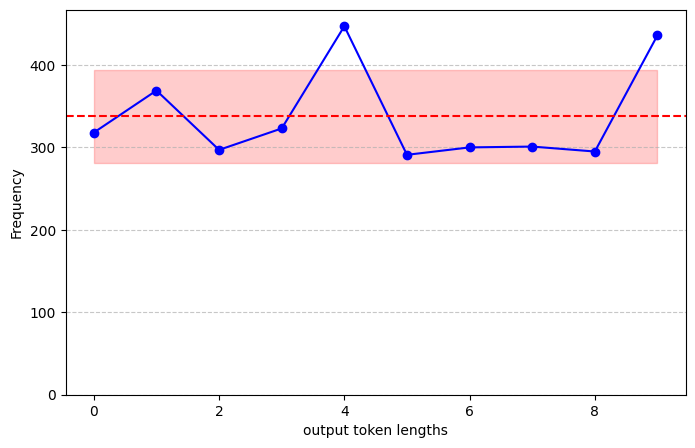

In [80]:
import matplotlib.pyplot as plt
import torch
import numpy as np

plot_data = out_lengths.cpu().numpy()
plot_std = np.std(plot_data)
plot_mean = np.mean(plot_data)

# Plot histogram
plt.figure(figsize=(8, 5))
#plt.hist(out_lengths.cpu().numpy(), bins=10, edgecolor='black', alpha=0.7)
plt.plot(range(len(plot_data)), plot_data, marker='o', linestyle='-', color='b', label="N values")
plt.axhline(y=plot_mean, color='r', linestyle='--', label="mean")
plt.fill_between(range(len(plot_data)), plot_mean-plot_std, plot_mean+plot_std, color='red', alpha=0.2, label="std-dev")

plt.xlabel("output token lengths")
plt.ylabel("Frequency")
plt.ylim(0, max(plot_data)+20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [81]:
output_forward = model.forward(inputs.to(device_str), output_hidden_states = True)

In [82]:
output_forward.__dict__.keys()

dict_keys(['loss', 'logits', 'past_key_values', 'hidden_states', 'attentions'])

In [83]:
len(output_forward.hidden_states)

27

In [86]:
# CHECK IF THE HIDDEN STATES FROM "forward" and "generate" are the same for the first token generation attempt

all([torch.all(output['hidden_states'][0][i] == output_forward['hidden_states'][i]).to('cpu') 
     for i in range(model.config.num_hidden_layers)])

True

In [8]:
# sentences = ["What is serendipity? Explain in maximum one paragraph."]
sentences = [{"role": "user", "content": "What is serendipity? Explain in maximum one paragraph."}]
print(tokenizer.decode(tokenizer.apply_chat_template(sentences, 
                                                     padding=padding, 
                                                     return_tensors=return_tensors, 
                                                     add_generation_prompt=add_generation_prompt)[0]))

<bos><start_of_turn>user
What is serendipity? Explain in maximum one paragraph.<end_of_turn>
<start_of_turn>model



In [9]:
sentences = [[{"role": "user", "content": "What is serendipity?"}]]*10

In [10]:
inputs = tokenizer.apply_chat_template(sentences, padding=padding, return_tensors=return_tensors, 
                                       add_generation_prompt=add_generation_prompt)

In [11]:
inputs.shape

torch.Size([10, 14])

In [12]:
print(tokenizer.batch_decode(inputs)[3])

<bos><start_of_turn>user
What is serendipity?<end_of_turn>
<start_of_turn>model



In [13]:
output = model.generate(inputs.to(device_str), generation_config=generation_config)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [14]:
output_str = tokenizer.batch_decode(output[:, inputs.shape[-1]:], skip_special_tokens=True)

In [15]:
for elem in output_str:
    print(f"{elem}")
    print(f"SIZE OF ELEM: {len(elem)}")
    print("============================================================\n")

Serendipity is the occurrence and development of events by chance in a happy or beneficial way. 

Here's a breakdown:

**Key Elements:**

* **Chance:** Serendipity relies on unexpected events and situations.
* **Happy or Beneficial:** The outcome of these chance encounters is usually positive or fortunate.
* **Development:**  It's not just a random event, but a series of events that unfold in a meaningful way.

**Examples:**

* Finding a lost item you were desperately looking for.
* Discovering a new favorite restaurant by accident.
* Meeting someone who changes your life.
* Stumbling upon a hidden gem while exploring a new city.

**The Psychology of Serendipity:**

* **Openness to new experiences:** Being willing to explore and try new things increases the chances of encountering serendipitous events.
* **Curiosity:** A curious mind is more likely to notice and appreciate unexpected opportunities.
* **Flexibility:** Being adaptable and open to change allows you to seize opportunities 

In [10]:
# sentences = ["What is serendipity? Explain in one sentence.", 
#              "When was Kennedy president?", 
#              "Write me a to-do list.", 
#              "Alice has 5 apples and Bob has 3. If Bob takes 1 apple from Alice, how many apples do both have at the end?"]

# sentences = ["What is serendipity? Explain in maximum one paragraph."]*4 
sentences = ["What is serendipity? Explain in maximum one paragraph."]


In [11]:
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(device_str)

In [12]:
inputs

{'input_ids': tensor([[     2,   1841,    603,   1369, 197762, 235336,  36576,    575,   7725,
            974,  16957, 235265]], device='cuda:1'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:1')}

In [86]:
tokenizer.max_len_single_sentence

1000000000000000019884624838655

In [53]:
print(tokenizer.get_chat_template())

{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '
' + message['content'] | trim + '<end_of_turn>
' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model
'}}{% endif %}


In [10]:
sentences = [
    #{"role": "user", "content": ""},
    #{"role": "assistant", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is serendipity? Explain in maximum one paragraph."},
]
print(tokenizer.decode(tokenizer.apply_chat_template(sentences, add_generation_prompt=True)))

<bos><start_of_turn>user
What is serendipity? Explain in maximum one paragraph.<end_of_turn>
<start_of_turn>model



In [58]:
inputs = tokenizer.apply_chat_template(sentences, padding=True, return_tensors="pt").to(device_str)

In [59]:
inputs

tensor([[     2,    106,   1645,    108,    107,    108,    106,   2516,    108,
           2045,    708,    476,  10055,  20409, 235265,    107,    108,    106,
           1645,    108,   1841,    603,   1369, 197762, 235336,  36576,    575,
           7725,    974,  16957, 235265,    107,    108]], device='cuda:1')

In [57]:
inputs = tokenizer(tokenizer.decode(tokenizer.apply_chat_template(sentences)), return_tensors="pt").to(device_str)

In [76]:
inputs.shape[1]

33

In [60]:
generation_config = GenerationConfig.from_pretrained(model_name, token=access_tk)
#generation_config.output_hidden_states = True
#generation_config.return_dict_in_generate = True
#generation_config.output_logits = True
generation_config.max_new_tokens = 10000
generation_config.pad_token_id = tokenizer.pad_token_id
generation_config.use_cache = True


In [62]:
output = model.generate(inputs, generation_config=generation_config)

In [73]:
output

tensor([[     2,    106,   1645,    108,    107,    108,    106,   2516,    108,
           2045,    708,    476,  10055,  20409, 235265,    107,    108,    106,
           1645,    108,   1841,    603,   1369, 197762, 235336,  36576,    575,
           7725,    974,  16957, 235265,    107,    108, 235287,   3191, 197762,
         235287,    603,    573,  28635,    578,   3505,    576,   5562,    731,
           7068,    575,    476,   4915,    689,  26014,   1703, 235265,   1165,
         235303, 235256,   1105,  10488,   2775,  14222,    689,   7103,  71024,
         235269,   3695,   1593,    476,  42006,  60154, 235265, 235248,    110,
            107]], device='cuda:1')

In [78]:
output_str = tokenizer.batch_decode(output[:,inputs.shape[1]:], skip_special_tokens=True)

In [82]:
for elem in output_str:
    print(f"{elem}")
    print(f"SIZE OF ELEM: {len(elem)}")
    print("\n")

*Serendipity* is the occurrence and development of events by chance in a happy or beneficial way. It's about finding something valuable or interesting unexpectedly, often through a fortunate coincidence. 



SIZE OF ELEM: 207




In [83]:
tokenizer.max_len_single_sentence

1000000000000000019884624838655

In [21]:
def tokenize_and_infer(model, generation_config, prompt):
    inputs = tokenizer(prompt, return_tensors='pt')
    input_ids = inputs.input_ids.to('cuda')
    output = model.generate(input_ids, 
                            generation_config=generation_config, 
                            attention_mask=inputs.attention_mask)
    # Return the length of the tokenized input, and the output from "generate"
    return len(inputs.input_ids[0]), output

In [32]:
input_len, output = tokenize_and_infer(model, generation_config, sentences[0])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [111]:
out_tokens = len(output.logits)
print(out_tokens)

27


In [105]:
output['sequences'][0]

tensor([128000,   3923,    374,   1446,    408,    575,    488,     30,  83017,
           304,    832,  11914,     13,   8409,    408,    575,    488,    374,
           279,  32659,    315,   9455,   2555,  15525,    477,  50189,    994,
           499,   3325,   1755,    433,     11,   3629,   1555,   6140,    477,
         16907,  13463,     13, 128009], device='cuda:0')

In [106]:
out_text = tokenizer.decode(output['sequences'][0][input_len:], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [107]:
out_text

' Serendipity is the occurrence of finding something valuable or delightful when you least expect it, often through chance or unexpected circumstances.'

In [108]:
input_len

13

In [33]:
output.__dict__.keys()

dict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

In [63]:
len(output.logits)

27

In [77]:
output.logits[0].shape

torch.Size([1, 128256])

In [135]:
len(output.hidden_states[2][0])

1

In [136]:
output.hidden_states[2][0].shape

torch.Size([1, 1, 2048])

In [ ]:
len(output['hidden_states'])

In [84]:
for elem in tokenizer.batch_decode(output['sequences'], skip_special_tokens=True, clean_up_tokenization_spaces=False): 
    print(f"###########################\n{elem}")

###########################
What is serendipity? Explain in one sentence. Serendipity is the occurrence of finding something valuable or delightful when you least expect it, often through chance or unexpected circumstances.


In [85]:
len(output['sequences'][0])

40

In [76]:
torch.all(output.hidden_states[0][-1][0,-1,:] == output.logits[0])

RuntimeError: The size of tensor a (2048) must match the size of tensor b (128256) at non-singleton dimension 1

In [52]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [3]:
messages = [
    {"role": "system",
     "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", 
     "content": "How many helicopters can a human eat in one sitting?"},
]

In [4]:
tokenizer.apply_chat_template(messages, tokenize=False)

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are a friendly chatbot who always responds in the style of a pirate<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow many helicopters can a human eat in one sitting?<|eot_id|>'

In [6]:
tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")


In [11]:
tokenized_chat

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,   2675,    527,
            264,  11919,   6369,   6465,    889,   2744,  31680,    304,    279,
           1742,    315,    264,  55066, 128009, 128006,    882, 128007,    271,
           4438,   1690,  59432,    649,    264,   3823,   8343,    304,    832,
          11961,     30, 128009, 128006,  78191, 128007,    271]])

In [12]:
print(tokenizer.decode(tokenized_chat[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a friendly chatbot who always responds in the style of a pirate<|eot_id|><|start_header_id|>user<|end_header_id|>

How many helicopters can a human eat in one sitting?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [13]:
generation_config = GenerationConfig.from_pretrained(model_name, token=access_tk)
generation_config.output_hidden_states = True
generation_config.return_dict_in_generate = True
generation_config.output_logits = True
generation_config.max_new_tokens = 10000

In [14]:
def inference(model, generation_config, tokenized_chat, output_states=True):
    with torch.no_grad():
        t_start = time.time()
        output = model.generate(tokenized_chat, generation_config=generation_config)
        t_gen_generate = time.time() - t_start
    
        t_start = time.time()
        output_call = model(tokenized_chat, output_hidden_states=True)
        t_gen_call = time.time() - t_start
        
    return output, output_call

In [15]:
output, output_call = inference(model, generation_config, tokenized_chat)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1934: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Starting from v4.46, the `logits` m

In [16]:
output.__dict__.keys()

dict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

In [17]:
for elem in tokenizer.batch_decode(output['sequences'], skip_special_tokens=True, clean_up_tokenization_spaces=False): 
    print(f"###########################\n{elem}")

###########################
system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a friendly chatbot who always responds in the style of a pirateuser

How many helicopters can a human eat in one sitting?assistant

Arrr, ye be askin' a mighty peculiar question, matey!  Eat a helicopter, ye say?  Well, I be thinkin' that be a bit o' a stretch fer even the most adventurous o' eaters.

Now, I be knowin' that humans be eatin' all sorts o' things, but a helicopter?  That be a mighty big chunk o' metal and machinery, don't ye think?  I be thinkin' it'd be more like tryin' to swallow a ship, savvy?

As fer the actual answer, I be thinkin' it be zero, matey.  Ye can't eat a helicopter, no matter how hungry ye be.  They be made o' metal and wires, not o' edible materials like biscuits or seafood.

But if ye be wantin' to know how many helicopters ye could eat if ye could eat 'em, I be thinkin' it be a mighty big number, but still zero, matey!  Ye can't eat a helicopter, 

In [35]:
def chat_tokenize_inference(model, generation_config, input_text, output_states=True):
    tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")
    with torch.no_grad():
        t_start = time.time()
        output = model.generate(tokenized_chat, generation_config=generation_config)
        t_gen_generate = time.time() - t_start
    
        t_start = time.time()
        output_call = model(tokenized_chat, output_hidden_states=True)
        t_gen_call = time.time() - t_start
        
    return output, output_call

In [36]:
def create_chat_template(question):
    return [
    {"role": "system",
     "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", 
     "content": f"{question}"},
    ]

In [37]:
sentences = ["What is serendipity?", 
             "When was Kennedy president?", 
             "Write me a to-do list.", 
             "Alice has 5 apples and Bob has 3. If Bob takes 1 apple from Alice, how many apples do both have at the end?"]

In [38]:
sentences = [create_chat_template(elem) for elem in sentences]

In [39]:
sentence_output = list()
reps = 5

for i in range(len(sentences)):
    cache = dict()
    for k in range(reps):
        output, output_call = chat_tokenize_inference(model, generation_config, sentences[i])
        cache[k] = (output, output_call)
    sentence_output.append(cache)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1934: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention 

In [40]:
def check_sentence_determinism(tmp):
    # Compare hidden_states between generate() and forward()
    if not all([torch.all(tmp[i][0]['hidden_states'][0][0] == tmp[i][1]['hidden_states'][0]).to('cpu') 
                for i in list(tmp.keys())]):
        return False
    # Compare logits between generate() and forward()
    elif not all([torch.all(tmp[i][0]['logits'][0] == tmp[i][1]['logits'][:,-1,:]).to('cpu') 
                  for i in list(tmp.keys())]):
        return False
    # Compare hidden_states across inference runs
    elif not all([torch.all(tmp[0][0]['hidden_states'][0][0] == tmp[i][0]['hidden_states'][0][0]).to('cpu') 
                  for i in range(1, len(list(tmp.keys())))]):
        return False
    # Compare logits across inference runs
    elif not all([torch.all(tmp[0][0]['logits'][0] == tmp[i][0]['logits'][0]).to('cpu') 
                  for i in range(1, len(list(tmp.keys())))]):
        return False
    else:
        return True
    

In [41]:
for i in range(len(sentence_output)):
    if not check_sentence_determinism(sentence_output[i]):
        print(f"Sentence {i} does not have same values somewhere!")
    else:
        print(f"Sentence {i} has deterministic hidden states and logits.")

Sentence 0 has deterministic hidden states and logits.
Sentence 1 has deterministic hidden states and logits.
Sentence 2 has deterministic hidden states and logits.
Sentence 3 has deterministic hidden states and logits.


In [10]:
from transformers import AutoTokenizer
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", token=access_tk)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [11]:
mistral_tokenizer.apply_chat_template(chat, tokenize=False)

"<s> [INST] Hello, how are you? [/INST] I'm doing great. How can I help you today?</s> [INST] I'd like to show off how chat templating works! [/INST]"